In [16]:
! pip install matplotlib pandas datashader bokeh holoviews umap-learn kmapper giotto-tda gudhi scikit-tda

Defaulting to user installation because normal site-packages is not writeable
  Using cached umap_learn-0.5.6-py3-none-any.whl.metadata (21 kB)
Using cached umap_learn-0.5.6-py3-none-any.whl (85 kB)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, parallel_config, delayed
from typing import Optional
import warnings
import sklearn
from kmapper import jupyter
import kmapper as km
import umap
import umap.plot
import hdbscan
import gudhi as gd
import gc

/home/local/.local/lib/python3.10/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
from ripser import ripser, Rips
from persim import plot_diagrams

In [3]:
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))

from MinioHandler import MinioHandler

In [4]:
TARGET_EPOCH = 65

In [5]:
def plot_epoch(epoch_dict: dict, num_epoch: int, max_dim: Optional[int] = 2, threshold: Optional[int] = None):
    '''
    epoch_dict: dict with epoch-wise matrices collected
    num_epoch: epoch to visualize (starts from 1)
    max_dim: homology groups to compute
    threshold: sets maximum radius for VR complex computation
    '''

    def plot_diag(ripser: Rips, data: dict, key: str, ax):
        matr = np.vstack(data[key])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            diag = ripser.fit_transform(matr)
            ripser.plot(diag, title=key, ax=ax)
        return None
    
    if threshold is None:
        threshold = np.inf

    data = epoch_dict[num_epoch]
    
    rips = Rips(maxdim=max_dim, thresh=threshold)

    types = list(data.keys())

    fig, ax = plt.subplots(nrows=1, ncols=len(types), figsize=(10, 6))

    #with parallel_config(backend="loky", n_jobs=2, ):
    #Parallel(return_as="generator")
    for i in range(len(types)):
        plot_diag(ripser=rips, 
                             data=data,
                             key=types[i],
                            ax=ax[i])
    return None

In [6]:
minio = MinioHandler()

In [7]:
tda_feats = minio.get_object("data/TDA_FEATURES/tda_save_dict_naive_cosine_with_pretrained_bert_high_lr.pkl", unpickle=True)

Shape

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
CPU times: user 5.1 s, sys: 1.83 s, total: 6.93 s
Wall time: 3.66 s


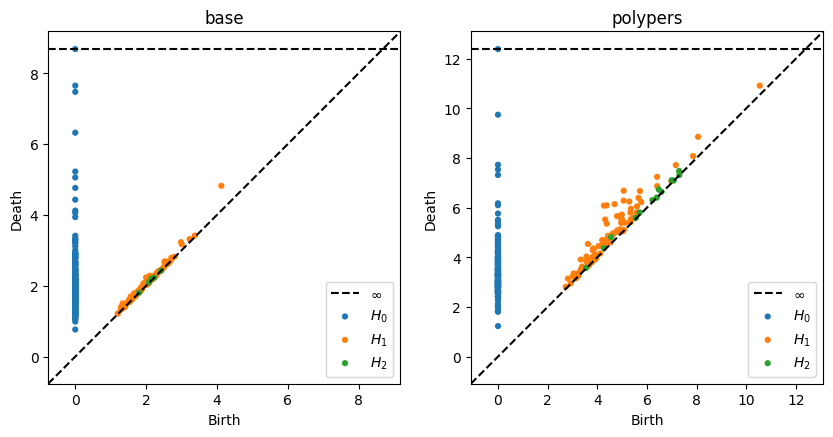

In [9]:
%%time
plot_epoch(tda_feats,
          num_epoch=TARGET_EPOCH)

In [10]:
data = tda_feats[TARGET_EPOCH]

In [11]:
base = np.c_[data["base"]]

polypers = np.c_[data["polypers"]]

### Clusterize and visualize

In [12]:
mapper = umap.UMAP(n_neighbors=30).fit(polypers)

/home/local/.local/lib/python3.10/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

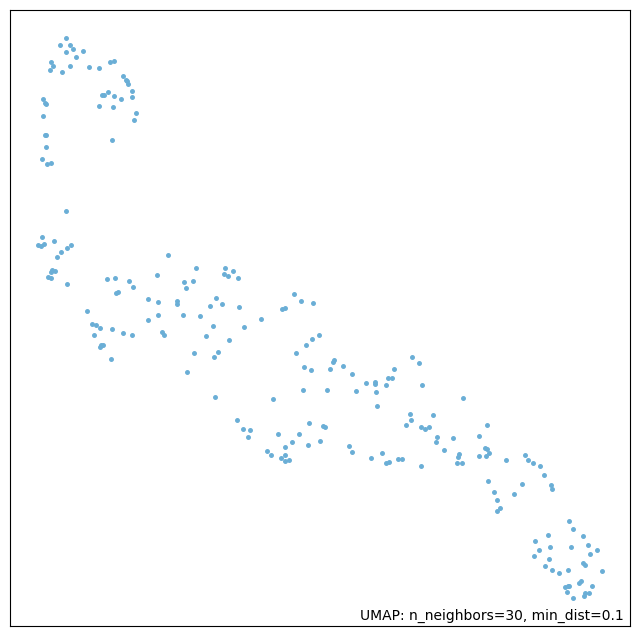

In [13]:
umap.plot.points(mapper)

### KeplerMapper construction based visualization

In [14]:
mapper = km.KeplerMapper(verbose=1)

KeplerMapper(verbose=1)


First project to lower-dimentional space through any mapping 

In [15]:
projected_data = mapper.project(base, 
                               projection=sklearn.decomposition.PCA(n_components=2),)

..Projecting on data shaped (240, 768)

..Projecting data using: 
	PCA(n_components=2)


..Scaling with: MinMaxScaler()



In [16]:
projected_data = mapper.fit_transform(base, 
                               projection=umap.UMAP())

..Composing projection pipeline of length 1:
	Projections: UMAP()
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (240, 768)

..Projecting data using: 
	UMAP(verbose=1)

UMAP( verbose=1)
Wed Apr 24 00:51:45 2024 Construct fuzzy simplicial set
Wed Apr 24 00:51:45 2024 Finding Nearest Neighbors
Wed Apr 24 00:51:45 2024 Finished Nearest Neighbor Search
Wed Apr 24 00:51:45 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Apr 24 00:51:48 2024 Finished embedding

..Scaling with: MinMaxScaler()



Cover the projected space with covers and clusterize inside covered pre-images (in higher dimentional space).

Then connect clusters in high-dimentional space if they share points in cover interconnections

In [17]:
scomplex = mapper.map(projected_data, 
                      base,
                      cover=km.Cover(n_cubes=10, 
                                     perc_overlap=0.2,),
                      clusterer=sklearn.cluster.OPTICS(min_samples=3, metric="euclidean"), 
                     )
                      

Mapping on data shaped (240, 768) using lens shaped (240, 2)

Creating 100 hypercubes.

Created 31 edges and 31 nodes in 0:00:03.397231.


However the algorithm is highly reliant on lens and clustering choise -- additional research is appreciated

In [18]:
# Visualize it
_ = mapper.visualize(scomplex, path_html="../logs/base_matrix.html",
                 title=f"base matrix; Epoch: {TARGET_EPOCH}")


jupyter.display(path_html="../logs/base_matrix.html")

Wrote visualization to: ../logs/base_matrix.html


/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [72]:
scomplex = mapper.map(projected_data, 
                      base,
                      cover=km.Cover(n_cubes=10, 
                                     perc_overlap=0.4,),
                      clusterer=hdbscan.HDBSCAN(min_cluster_size=3, )
                     )
                      

Mapping on data shaped (240, 768) using lens shaped (240, 2)

Creating 100 hypercubes.

Created 38 edges and 21 nodes in 0:00:00.069027.


In [73]:
# Visualize it
_ = mapper.visualize(scomplex, path_html="../logs/base_matrix.html",
                 title=f"base matrix; Epoch: {TARGET_EPOCH}")


jupyter.display(path_html="../logs/base_matrix.html")

Wrote visualization to: logs/base_matrix.html


/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Polypers

In [77]:
projected_data = mapper.project(polypers, 
                               projection=sklearn.decomposition.PCA(n_components=2),)

..Projecting on data shaped (240, 768)

..Projecting data using: 
	PCA(n_components=2)


..Scaling with: MinMaxScaler()



In [81]:
projected_data = mapper.fit_transform(polypers, 
                               projection=umap.UMAP())

..Composing projection pipeline of length 1:
	Projections: UMAP()
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (240, 768)

..Projecting data using: 
	UMAP(verbose=1)

UMAP( verbose=1)
Tue Apr 23 23:44:00 2024 Construct fuzzy simplicial set
Tue Apr 23 23:44:00 2024 Finding Nearest Neighbors
Tue Apr 23 23:44:00 2024 Finished Nearest Neighbor Search
Tue Apr 23 23:44:00 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Apr 23 23:44:02 2024 Finished embedding

..Scaling with: MinMaxScaler()



Cover the projected space with covers and clusterize inside covered pre-images (in higher dimentional space).

Then connect clusters in high-dimentional space if they share points in cover interconnections

In [106]:
scomplex = mapper.map(projected_data, 
                      polypers,
                      cover=km.Cover(n_cubes=10, 
                                     perc_overlap=0.2,),
                      clusterer=sklearn.cluster.OPTICS(min_samples=3, metric="euclidean"), 
                     )
                      

Mapping on data shaped (240, 768) using lens shaped (240, 2)

Creating 100 hypercubes.

Created 36 edges and 49 nodes in 0:00:01.611497.


However the algorithm is highly reliant on lens and clustering choise -- additional research is appreciated

In [107]:
# Visualize it
_ = mapper.visualize(scomplex, path_html="../logs/polypers_matrix.html",
                 title=f"polypers matrix; Epoch: {TARGET_EPOCH}")


jupyter.display(path_html="../logs/polypers_matrix.html")

Wrote visualization to: logs/polypers_matrix.html


/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [110]:
scomplex = mapper.map(projected_data, 
                      polypers,
                      cover=km.Cover(n_cubes=10, 
                                     perc_overlap=0.5,),
                      clusterer=hdbscan.HDBSCAN(min_cluster_size=2, )
                     )
                      

Mapping on data shaped (240, 768) using lens shaped (240, 2)

Creating 100 hypercubes.

Created 126 edges and 84 nodes in 0:00:00.102747.


In [111]:
# Visualize it
_ = mapper.visualize(scomplex, path_html="../logs/polypers_matrix.html",
                 title=f"polypers matrix; Epoch: {TARGET_EPOCH}")


jupyter.display(path_html="../logs/polypers_matrix.html")

Wrote visualization to: logs/polypers_matrix.html


/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Using gudhi

In [126]:
def plot_persistance(pt_cloud: np.array, max_dim = 2, max_edge_length = np.inf):

    skeleton = gd.RipsComplex(points = pt_cloud, max_edge_length = max_edge_length)
    
    rips_tree = skeleton.create_simplex_tree(max_dimension = max_dim)

    print(f"Dimension: {rips_tree.dimension()}")

    print(f"Num_simplices: {rips_tree.num_simplices()}")

    val = input('Plot persistence diagram: y/n')

    if val == "y":
        gd.persistence_graphical_tools.plot_persistence_diagram(rips_tree.persistence())
        print(f"Persistent_betti_numbers: {rips_tree.persistent_betti_numbers(from_value=0, to_value=4)}")
        
    return rips_tree
    

Dimension: 2
Num_simplices: 2304200


Plot persistence diagram: y/n y


Persistent_betti_numbers: [10, 0]


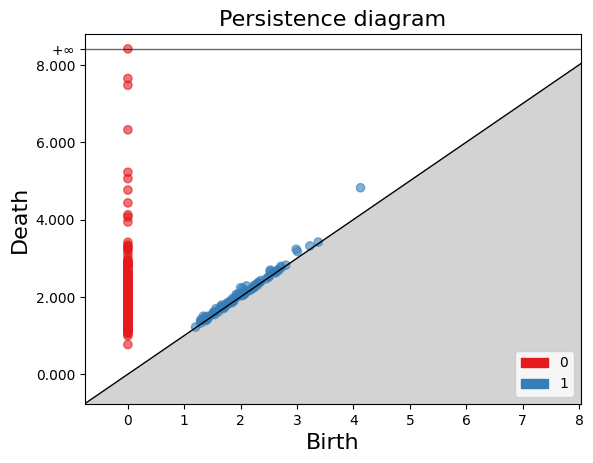

In [120]:
plot_persistance(base, max_dim=2,)

Dimension: 2
Num_simplices: 2304200


Plot persistence diagram: y/n y


Persistent_betti_numbers: [10, 0]


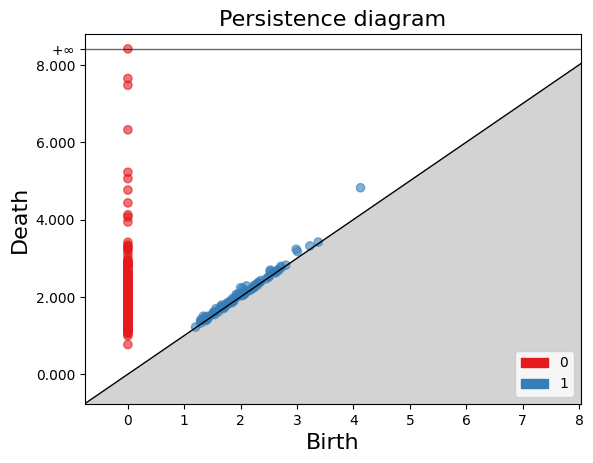

In [127]:
tree = plot_persistance(base, max_dim=2)

In [139]:
tree